# Phase 5: ADE vs Boundary Proximity Correlation

This notebook investigates the relationship between:
1. **Trajectory prediction quality** (min_ADE from Alpamayo-R1)
2. **Classification boundary proximity** (distance to centroids in embedding space)

**Hypothesis**: Scenes that fall near classification boundaries (transition regions) may be harder for trajectory prediction, resulting in higher ADE.

**Data Sources:**
- Alpamayo inference: `data/alpamayo_inference/workstation/inference_20260120_143136.json`
- Classification embeddings: `data/runs/classification_20260120/embeddings.npz`
- Centroids: `data/runs/classification_20260120/centroids.json`

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

# Configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

# Paths
BASE_DIR = Path('/Users/kaiser/Projects/Masterarbeit')
DATA_DIR = BASE_DIR / 'data' / 'runs' / 'classification_20260120'
# Use the 100-sample Alpamayo inference file
ALPAMAYO_FILE = BASE_DIR / 'data' / 'alpamayo_inference' / 'inference_20260120_154727.json'
FIGURE_DIR = DATA_DIR / 'figures'
FIGURE_DIR.mkdir(exist_ok=True)

print(f"Using Alpamayo file: {ALPAMAYO_FILE.name}")

Using Alpamayo file: inference_20260120_154727.json


## 1. Load Data

In [2]:
# Load Alpamayo inference results
with open(ALPAMAYO_FILE) as f:
    alpamayo_data = json.load(f)

# Extract clip IDs and ADE values
alpamayo_clips = {r['clip_id']: r for r in alpamayo_data['results']}
print(f"Alpamayo clips: {len(alpamayo_clips)}")
for clip_id, result in alpamayo_clips.items():
    print(f"  {clip_id[:8]}... ADE={result['min_ade']:.3f}")

Alpamayo clips: 100
  eb385dff... ADE=2.760
  cbbeaf68... ADE=3.210
  19c65d59... ADE=3.459
  7e445f8c... ADE=1.134
  0fdccd4d... ADE=1.835
  67f38dd6... ADE=0.324
  be0e7715... ADE=1.810
  9a5cd9e4... ADE=0.729
  88db6b7d... ADE=0.649
  8c4b1d06... ADE=0.803
  fc814796... ADE=0.105
  f20fa181... ADE=2.373
  9b8da3a0... ADE=1.165
  01460b45... ADE=0.065
  3aba15fb... ADE=0.186
  a11c2afd... ADE=7.347
  e2897287... ADE=1.274
  0248180b... ADE=1.739
  86042f86... ADE=0.605
  88bc8ff7... ADE=1.351
  09ae668d... ADE=1.446
  f35dbc43... ADE=0.971
  361a388a... ADE=1.955
  365d6765... ADE=6.762
  c8d2b0b2... ADE=0.825
  94d9d0f3... ADE=3.115
  e9120280... ADE=1.348
  bb3d07b0... ADE=0.001
  f0bc1fcf... ADE=1.425
  cb474d91... ADE=1.820
  994af02f... ADE=1.848
  0871a728... ADE=2.135
  a19e8f2a... ADE=0.937
  b893dabc... ADE=0.658
  14850e11... ADE=0.676
  e0fae34c... ADE=0.696
  ed7a5093... ADE=1.885
  32bd0d58... ADE=1.516
  6b0424a3... ADE=1.573
  260dbc4d... ADE=0.264
  0350f6d8... ADE=4.

In [3]:
# Load classification embeddings
emb_data = np.load(DATA_DIR / 'embeddings.npz')
embeddings = emb_data['embeddings']  # (n_scenes, n_keys, dim)
clip_ids = emb_data['clip_ids'].tolist()
keys = emb_data['keys'].tolist()

print(f"Embeddings shape: {embeddings.shape}")
print(f"Clip IDs: {len(clip_ids)}")
print(f"Keys: {len(keys)}")

Embeddings shape: (26, 19, 4096)
Clip IDs: 26
Keys: 19


In [4]:
# Load centroids
with open(DATA_DIR / 'centroids.json') as f:
    centroids_data = json.load(f)

# Load classification texts
with open(DATA_DIR / 'embedding_texts.json') as f:
    texts_data = json.load(f)
all_texts = texts_data['texts']

print(f"Keys with centroids: {len(centroids_data)}")

Keys with centroids: 19


In [5]:
# Find matching clip indices
matched_clips = []
for clip_id in alpamayo_clips.keys():
    if clip_id in clip_ids:
        idx = clip_ids.index(clip_id)
        matched_clips.append({
            'clip_id': clip_id,
            'scene_idx': idx,
            'min_ade': alpamayo_clips[clip_id]['min_ade'],
            'coc_reasoning': alpamayo_clips[clip_id]['coc_reasoning'][0][0]
        })

print(f"Matched clips: {len(matched_clips)} / {len(alpamayo_clips)}")
for m in matched_clips:
    print(f"  Scene {m['scene_idx']}: ADE={m['min_ade']:.3f}")

Matched clips: 25 / 100
  Scene 0: ADE=2.760
  Scene 1: ADE=3.210
  Scene 2: ADE=3.459
  Scene 3: ADE=1.134
  Scene 4: ADE=1.835
  Scene 5: ADE=0.324
  Scene 6: ADE=1.810
  Scene 7: ADE=0.729
  Scene 8: ADE=0.649
  Scene 9: ADE=0.803
  Scene 10: ADE=0.105
  Scene 14: ADE=2.373
  Scene 11: ADE=1.165
  Scene 12: ADE=0.065
  Scene 13: ADE=0.186
  Scene 15: ADE=7.347
  Scene 16: ADE=1.274
  Scene 17: ADE=1.739
  Scene 18: ADE=0.605
  Scene 20: ADE=1.351
  Scene 21: ADE=1.446
  Scene 22: ADE=0.971
  Scene 23: ADE=1.955
  Scene 24: ADE=6.762
  Scene 25: ADE=0.825


## 2. Compute Boundary Proximity Metrics

For each scene and each key, compute:
1. **Distance to own centroid**: How far is this scene's embedding from the centroid of its class?
2. **Distance to nearest other centroid**: How close is the scene to a different class?
3. **Margin**: Distance to own centroid minus distance to nearest other centroid (negative = closer to boundary)

In [6]:
def cosine_distance(a, b):
    """Compute cosine distance (1 - similarity)."""
    return 1.0 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_scene_value(scene_idx, key_idx):
    """Extract the classification value for a scene and key."""
    text = all_texts[scene_idx][key_idx]
    return text.split(': ', 1)[1] if ': ' in text else text

def compute_boundary_metrics(scene_idx, key, key_idx, embeddings, centroids_data):
    """Compute boundary proximity metrics for a scene and key."""
    if key not in centroids_data:
        return None
    
    scene_emb = embeddings[scene_idx, key_idx]
    scene_value = get_scene_value(scene_idx, key_idx)
    
    key_centroids = centroids_data[key]
    
    if scene_value not in key_centroids:
        return None
    
    # Distance to own centroid
    own_centroid = np.array(key_centroids[scene_value]['centroid'])
    dist_to_own = cosine_distance(scene_emb, own_centroid)
    
    # Distance to other centroids
    other_dists = []
    for value, data in key_centroids.items():
        if value != scene_value:
            other_centroid = np.array(data['centroid'])
            other_dists.append(cosine_distance(scene_emb, other_centroid))
    
    if not other_dists:
        return None
    
    dist_to_nearest_other = min(other_dists)
    
    # Margin: positive = far from boundary, negative = near boundary
    margin = dist_to_nearest_other - dist_to_own
    
    return {
        'key': key,
        'value': scene_value,
        'dist_to_own': dist_to_own,
        'dist_to_nearest_other': dist_to_nearest_other,
        'margin': margin,
    }

In [7]:
# Keys to analyze (same as interpolation keys)
ANALYZE_KEYS = [
    'weather', 'time_of_day', 'road_type', 'traffic_situation',
    'pedestrians_present', 'construction_activity', 'traffic_signals_visible',
    'occlusion_level', 'depth_complexity', 'visual_degradation',
    'similar_object_confusion', 'safety_criticality', 'required_action'
]

# Compute metrics for all matched clips
scene_metrics = []

for m in matched_clips:
    scene_idx = m['scene_idx']
    clip_id = m['clip_id']
    min_ade = m['min_ade']
    
    key_metrics = {}
    for key in ANALYZE_KEYS:
        if key in keys:
            key_idx = keys.index(key)
            metrics = compute_boundary_metrics(scene_idx, key, key_idx, embeddings, centroids_data)
            if metrics:
                key_metrics[key] = metrics
    
    # Aggregate metrics
    if key_metrics:
        margins = [m['margin'] for m in key_metrics.values()]
        dists_to_own = [m['dist_to_own'] for m in key_metrics.values()]
        
        scene_metrics.append({
            'clip_id': clip_id,
            'scene_idx': scene_idx,
            'min_ade': min_ade,
            'mean_margin': np.mean(margins),
            'min_margin': np.min(margins),
            'mean_dist_to_own': np.mean(dists_to_own),
            'key_metrics': key_metrics,
            'coc_reasoning': m['coc_reasoning']
        })

print(f"Computed metrics for {len(scene_metrics)} scenes")

Computed metrics for 25 scenes


In [8]:
# Display summary table
print(f"{'Scene':<8} {'ADE':>8} {'MeanMargin':>12} {'MinMargin':>12} {'MeanDistOwn':>12}")
print("-" * 56)
for sm in scene_metrics:
    print(f"{sm['scene_idx']:<8} {sm['min_ade']:>8.3f} {sm['mean_margin']:>12.4f} {sm['min_margin']:>12.4f} {sm['mean_dist_to_own']:>12.4f}")

Scene         ADE   MeanMargin    MinMargin  MeanDistOwn
--------------------------------------------------------
0           2.760       0.1063       0.0410      -0.0000
1           3.210       0.1079       0.0410      -0.0000
2           3.459       0.1105       0.0410      -0.0000
3           1.134       0.1099       0.0410      -0.0000
4           1.835       0.1139       0.0410      -0.0000
5           0.324       0.1128       0.0410      -0.0000
6           1.810       0.1113       0.0410      -0.0000
7           0.729       0.1095       0.0410      -0.0000
8           0.649       0.1114       0.0410      -0.0000
9           0.803       0.1132       0.0410      -0.0000
10          0.105       0.1137       0.0410      -0.0000
14          2.373       0.1148       0.0410      -0.0000
11          1.165       0.1099       0.0410      -0.0000
12          0.065       0.1166       0.0410      -0.0000
13          0.186       0.1127       0.0410      -0.0000
15          7.347       0.1085 

## 3. Correlation Analysis

In [9]:
# Extract arrays for correlation
ade_values = np.array([sm['min_ade'] for sm in scene_metrics])
mean_margins = np.array([sm['mean_margin'] for sm in scene_metrics])
min_margins = np.array([sm['min_margin'] for sm in scene_metrics])
mean_dists = np.array([sm['mean_dist_to_own'] for sm in scene_metrics])

print("Correlation with min_ADE:")
print(f"  Mean margin:      r={np.corrcoef(ade_values, mean_margins)[0,1]:.4f}")
print(f"  Min margin:       r={np.corrcoef(ade_values, min_margins)[0,1]:.4f}")
print(f"  Mean dist to own: r={np.corrcoef(ade_values, mean_dists)[0,1]:.4f}")

Correlation with min_ADE:
  Mean margin:      r=-0.5134
  Min margin:       r=0.1417
  Mean dist to own: r=-0.4859


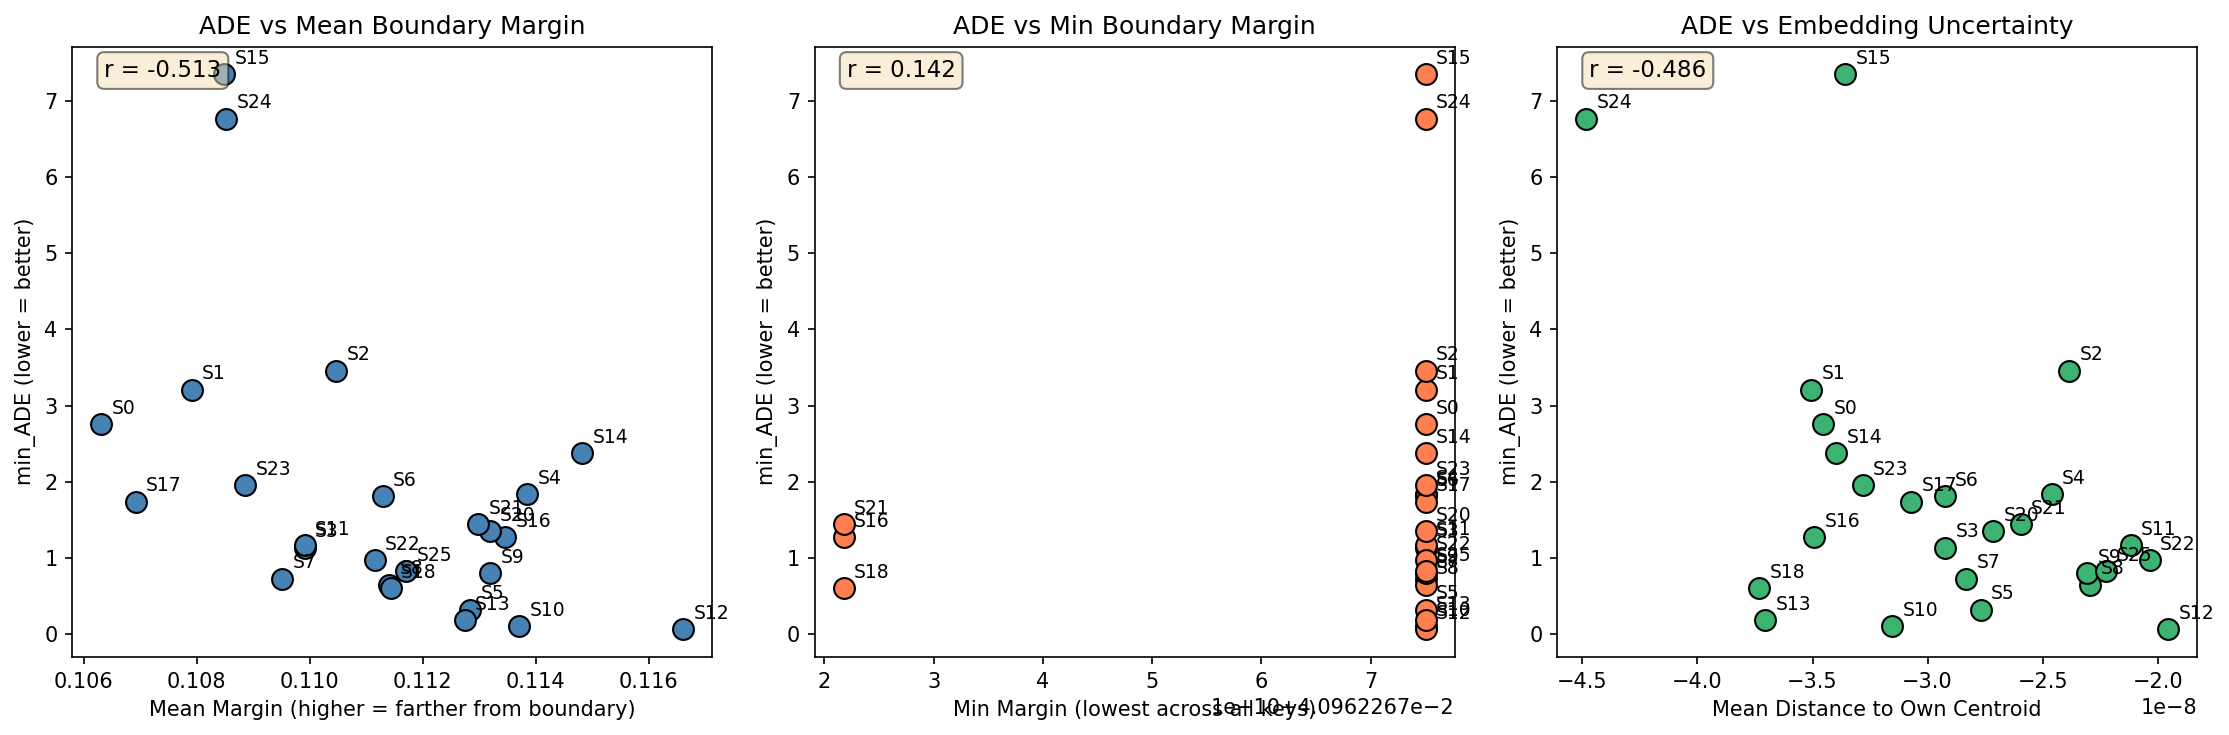

In [10]:
# Scatter plot: ADE vs Mean Margin
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: ADE vs Mean Margin
ax = axes[0]
ax.scatter(mean_margins, ade_values, s=100, c='steelblue', edgecolors='black', linewidth=1)
for i, sm in enumerate(scene_metrics):
    ax.annotate(f"S{sm['scene_idx']}", (mean_margins[i], ade_values[i]), 
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax.set_xlabel('Mean Margin (higher = farther from boundary)')
ax.set_ylabel('min_ADE (lower = better)')
ax.set_title('ADE vs Mean Boundary Margin')
r = np.corrcoef(ade_values, mean_margins)[0, 1]
ax.annotate(f'r = {r:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: ADE vs Min Margin
ax = axes[1]
ax.scatter(min_margins, ade_values, s=100, c='coral', edgecolors='black', linewidth=1)
for i, sm in enumerate(scene_metrics):
    ax.annotate(f"S{sm['scene_idx']}", (min_margins[i], ade_values[i]),
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax.set_xlabel('Min Margin (lowest across all keys)')
ax.set_ylabel('min_ADE (lower = better)')
ax.set_title('ADE vs Min Boundary Margin')
r = np.corrcoef(ade_values, min_margins)[0, 1]
ax.annotate(f'r = {r:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: ADE vs Mean Distance to Own Centroid
ax = axes[2]
ax.scatter(mean_dists, ade_values, s=100, c='mediumseagreen', edgecolors='black', linewidth=1)
for i, sm in enumerate(scene_metrics):
    ax.annotate(f"S{sm['scene_idx']}", (mean_dists[i], ade_values[i]),
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax.set_xlabel('Mean Distance to Own Centroid')
ax.set_ylabel('min_ADE (lower = better)')
ax.set_title('ADE vs Embedding Uncertainty')
r = np.corrcoef(ade_values, mean_dists)[0, 1]
ax.annotate(f'r = {r:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
fig.savefig(FIGURE_DIR / '05_ade_boundary_correlation.png', bbox_inches='tight')
plt.show()

## 4. Per-Key Analysis

Which semantic keys are most predictive of trajectory prediction error?

In [11]:
# Compute per-key correlations
key_correlations = {}

for key in ANALYZE_KEYS:
    margins_for_key = []
    ades_for_key = []
    
    for sm in scene_metrics:
        if key in sm['key_metrics']:
            margins_for_key.append(sm['key_metrics'][key]['margin'])
            ades_for_key.append(sm['min_ade'])
    
    if len(margins_for_key) >= 3:
        r = np.corrcoef(ades_for_key, margins_for_key)[0, 1]
        key_correlations[key] = r

# Sort by absolute correlation
sorted_keys = sorted(key_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("Per-Key Correlation (ADE vs Margin):")
print("-" * 45)
for key, r in sorted_keys:
    direction = "↑ ADE near boundary" if r < 0 else "↓ ADE near boundary"
    print(f"{key:<30} r={r:>7.3f}  {direction}")

Per-Key Correlation (ADE vs Margin):
---------------------------------------------
occlusion_level                r= -0.391  ↑ ADE near boundary
traffic_signals_visible        r=  0.354  ↓ ADE near boundary
road_type                      r= -0.344  ↑ ADE near boundary
pedestrians_present            r=  0.244  ↓ ADE near boundary
safety_criticality             r= -0.211  ↑ ADE near boundary
time_of_day                    r= -0.184  ↑ ADE near boundary
depth_complexity               r=  0.163  ↓ ADE near boundary
similar_object_confusion       r=  0.142  ↓ ADE near boundary
visual_degradation             r=  0.140  ↓ ADE near boundary
construction_activity          r= -0.099  ↑ ADE near boundary
required_action                r=  0.094  ↓ ADE near boundary
traffic_situation              r=  0.086  ↓ ADE near boundary
weather                        r= -0.067  ↑ ADE near boundary


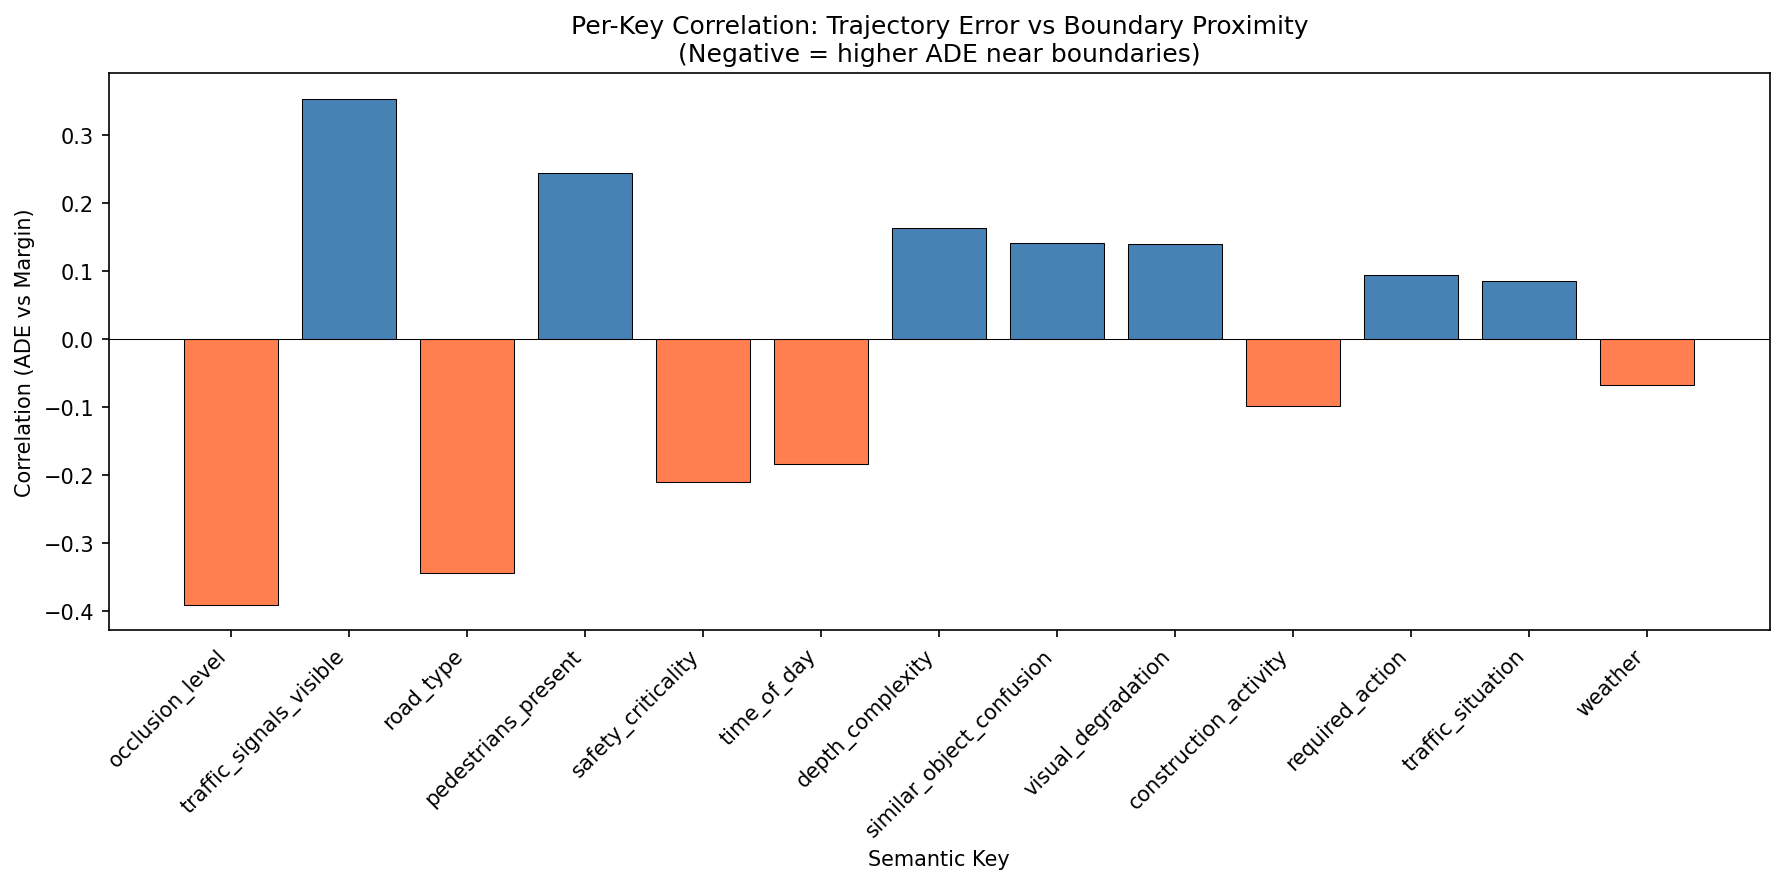

In [12]:
# Bar plot of per-key correlations
fig, ax = plt.subplots(figsize=(12, 6))

keys_sorted = [k for k, r in sorted_keys]
correlations = [r for k, r in sorted_keys]

colors = ['coral' if r < 0 else 'steelblue' for r in correlations]
bars = ax.bar(range(len(keys_sorted)), correlations, color=colors, edgecolor='black', linewidth=0.5)

ax.set_xticks(range(len(keys_sorted)))
ax.set_xticklabels(keys_sorted, rotation=45, ha='right')
ax.set_xlabel('Semantic Key')
ax.set_ylabel('Correlation (ADE vs Margin)')
ax.set_title('Per-Key Correlation: Trajectory Error vs Boundary Proximity\n(Negative = higher ADE near boundaries)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '05_perkey_ade_correlation.png', bbox_inches='tight')
plt.show()

## 5. Scene Detail View

Detailed breakdown for each scene showing classifications and boundary metrics.

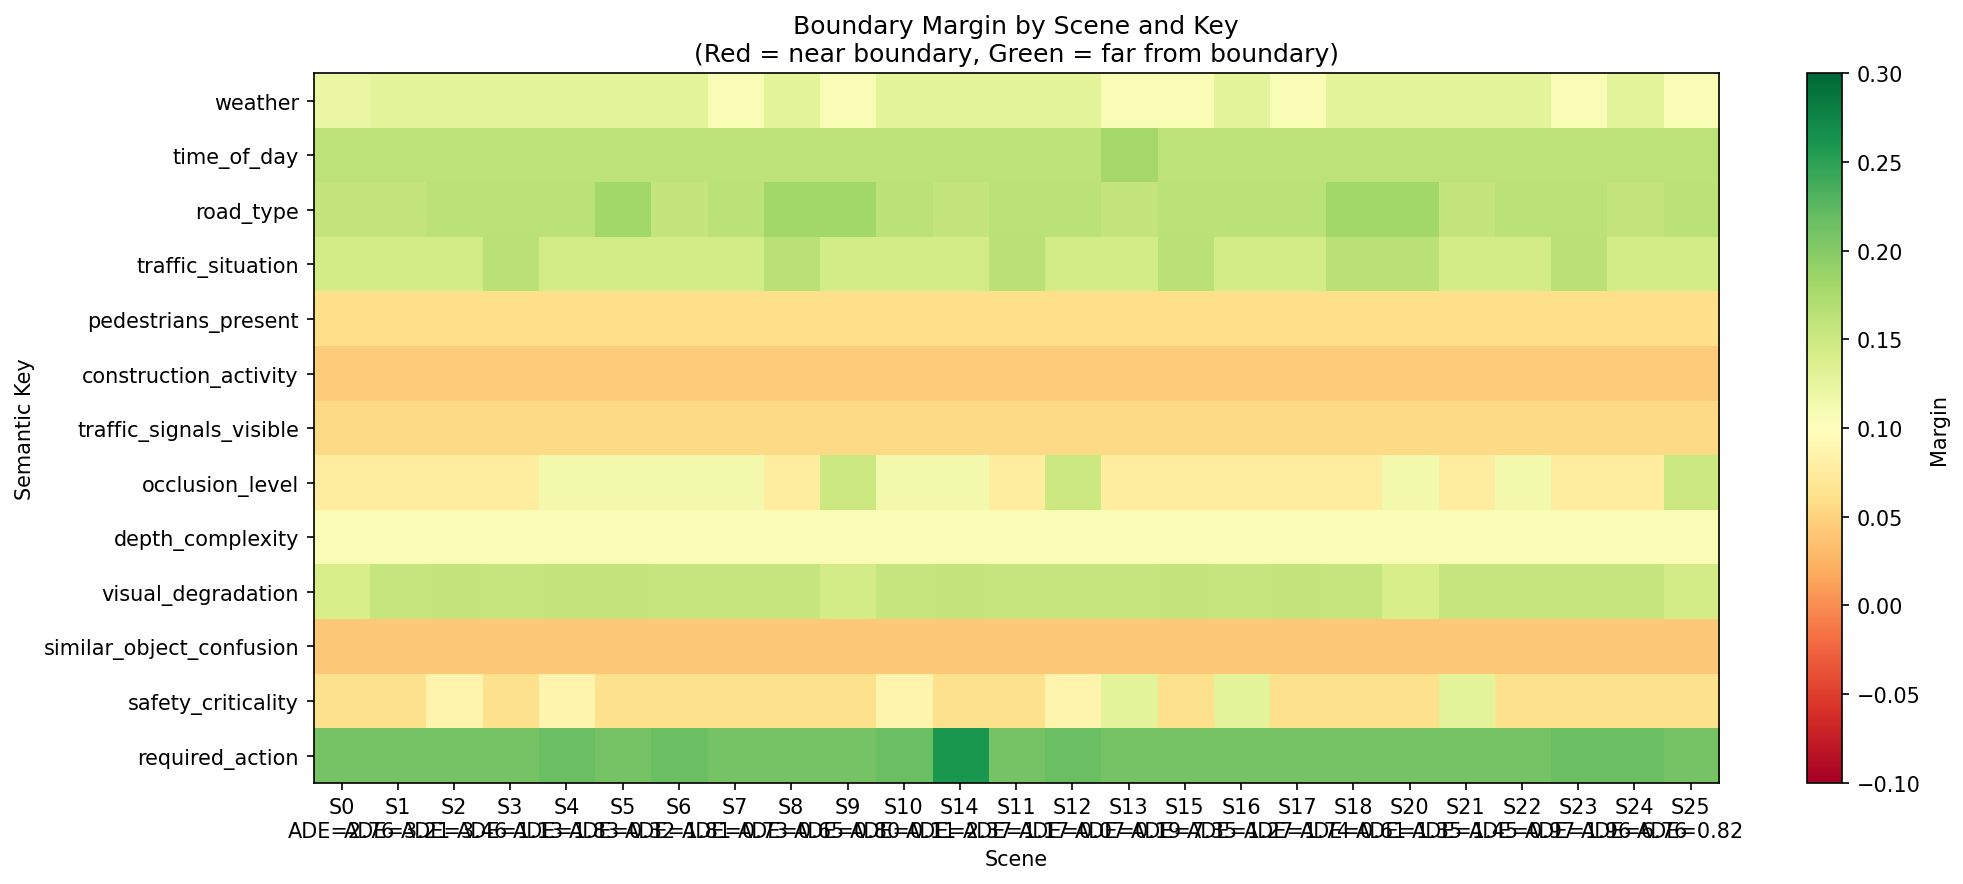

In [13]:
# Heatmap of margins per scene per key
fig, ax = plt.subplots(figsize=(14, 6))

# Build matrix
scene_labels = [f"S{sm['scene_idx']}\nADE={sm['min_ade']:.2f}" for sm in scene_metrics]
matrix = np.full((len(scene_metrics), len(ANALYZE_KEYS)), np.nan)

for i, sm in enumerate(scene_metrics):
    for j, key in enumerate(ANALYZE_KEYS):
        if key in sm['key_metrics']:
            matrix[i, j] = sm['key_metrics'][key]['margin']

# Plot heatmap
im = ax.imshow(matrix.T, cmap='RdYlGn', aspect='auto', vmin=-0.1, vmax=0.3)

ax.set_xticks(range(len(scene_metrics)))
ax.set_xticklabels(scene_labels)
ax.set_yticks(range(len(ANALYZE_KEYS)))
ax.set_yticklabels(ANALYZE_KEYS)

ax.set_xlabel('Scene')
ax.set_ylabel('Semantic Key')
ax.set_title('Boundary Margin by Scene and Key\n(Red = near boundary, Green = far from boundary)')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Margin')

plt.tight_layout()
fig.savefig(FIGURE_DIR / '05_margin_heatmap.png', bbox_inches='tight')
plt.show()

In [14]:
# Print detailed scene info
for sm in sorted(scene_metrics, key=lambda x: x['min_ade'], reverse=True):
    print(f"\n{'='*60}")
    print(f"Scene {sm['scene_idx']} | ADE: {sm['min_ade']:.3f} | Mean Margin: {sm['mean_margin']:.4f}")
    print(f"Reasoning: {sm['coc_reasoning']}")
    print(f"-"*60)
    
    # Sort keys by margin (most boundary-proximate first)
    scene_sorted_keys = sorted(sm['key_metrics'].items(), key=lambda x: x[1]['margin'])
    for key, km in scene_sorted_keys[:5]:  # Top 5 closest to boundary
        print(f"  {key}: {km['value']} (margin={km['margin']:.4f})")


Scene 15 | ADE: 7.347 | Mean Margin: 0.1085
Reasoning: Keep distance to the lead vehicle because it is ahead in the same lane.
------------------------------------------------------------
  similar_object_confusion: true (margin=0.0410)
  construction_activity: false (margin=0.0452)
  traffic_signals_visible: false (margin=0.0552)
  pedestrians_present: false (margin=0.0596)
  safety_criticality: tier1_catastrophic (margin=0.0622)

Scene 24 | ADE: 6.762 | Mean Margin: 0.1085
Reasoning: Keep speed due to the lead vehicle maintaining a steady pace with a stable gap.
------------------------------------------------------------
  similar_object_confusion: true (margin=0.0410)
  construction_activity: false (margin=0.0452)
  traffic_signals_visible: false (margin=0.0552)
  pedestrians_present: false (margin=0.0596)
  safety_criticality: tier1_catastrophic (margin=0.0622)

Scene 2 | ADE: 3.459 | Mean Margin: 0.1105
Reasoning: Keep distance to the lead vehicle because it is ahead in the same

## 6. Summary

Key findings from the boundary proximity vs trajectory prediction analysis.

In [15]:
# Summary statistics
print("="*60)
print("SUMMARY: Boundary Proximity vs Trajectory Prediction")
print("="*60)
print(f"\nSample size: {len(scene_metrics)} scenes")
print(f"ADE range: {min(ade_values):.3f} - {max(ade_values):.3f}")

# Handle potential NaN in correlations
r_mean = np.corrcoef(ade_values, mean_margins)[0,1]
r_min = np.corrcoef(ade_values, min_margins)[0,1] if np.std(min_margins) > 0 else float('nan')
r_dist = np.corrcoef(ade_values, mean_dists)[0,1]

print(f"\nOverall Correlations (ADE vs Metric):")
print(f"  Mean margin:      r = {r_mean:>7.4f}")
print(f"  Min margin:       r = {r_min:>7.4f}")
print(f"  Mean dist to own: r = {r_dist:>7.4f}")

print(f"\nTop 3 Most Predictive Keys (by |correlation|):")
# Filter out NaN correlations
valid_sorted_keys = [(k, r) for k, r in sorted_keys if not np.isnan(r)]
for key, r in valid_sorted_keys[:3]:
    print(f"  {key}: r = {r:.4f}")

print(f"\nInterpretation:")
if np.isnan(r_mean):
    print("  → Insufficient variance to compute correlation.")
elif r_mean < -0.3:
    print("  → Negative correlation: Scenes near classification boundaries")
    print("    tend to have HIGHER trajectory prediction error (ADE).")
elif r_mean > 0.3:
    print("  → Positive correlation: Scenes far from classification boundaries")
    print("    tend to have HIGHER trajectory prediction error (ADE).")
else:
    print("  → Weak correlation: Boundary proximity has limited predictive")
    print("    power for trajectory prediction quality with this sample size.")

SUMMARY: Boundary Proximity vs Trajectory Prediction

Sample size: 25 scenes
ADE range: 0.065 - 7.347

Overall Correlations (ADE vs Metric):
  Mean margin:      r = -0.5134
  Min margin:       r =  0.1417
  Mean dist to own: r = -0.4859

Top 3 Most Predictive Keys (by |correlation|):
  occlusion_level: r = -0.3914
  traffic_signals_visible: r = 0.3537
  road_type: r = -0.3437

Interpretation:
  → Negative correlation: Scenes near classification boundaries
    tend to have HIGHER trajectory prediction error (ADE).


In [16]:
# List generated figures
print('\nGenerated figures:')
for f in sorted(FIGURE_DIR.glob('05_*.png')):
    print(f'  {f.name}')


Generated figures:
  05_ade_boundary_correlation.png
  05_margin_heatmap.png
  05_perkey_ade_correlation.png
